## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (plus script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells`.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Simple Data Analysis and Linear and MLP Regression Modelling

## The `housing` problem

We want to predict median house values in suburbs of Boston.

Accesible en https://archive.ics.uci.edu/ml/datasets/Housing

### Attribute Information:

1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per \$10,000 
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population 
14. MEDV: Median value of owner-occupied homes in \$1000's

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import time
import pickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.svm import SVR

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.datasets import load_boston

## Data Loading

The dataset is preloaded in the sciki-learn library.

In [4]:
boston_data = load_boston()

df_housing = pd.DataFrame(data=boston_data['data'], columns=boston_data['feature_names'])
df_housing['MEDV'] = boston_data['target']

print ("nFilas: %d\tnColumnas: %d\n" % (df_housing.shape[0], df_housing.shape[1]) )
print ("Columnas:\t", np.array(df_housing.columns))

nFilas: 506	nColumnas: 14

Columnas:	 ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT' 'MEDV']


In [5]:
vars_housing   = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', \
                  'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
target_housing = ['MEDV']

## Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms

### Descriptive analysis

In [6]:
df_housing.describe().round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.61,8.60,0.01,0.08,0.26,3.68,88.98
ZN,506.0,11.36,23.32,0.00,0.00,0.00,12.50,100.00
INDUS,506.0,11.14,6.86,0.46,5.19,9.69,18.10,27.74
CHAS,506.0,0.07,0.25,0.00,0.00,0.00,0.00,1.00
NOX,506.0,0.55,0.12,0.38,0.45,0.54,0.62,0.87
RM,506.0,6.28,0.70,3.56,5.89,6.21,6.62,8.78
AGE,506.0,68.57,28.15,2.90,45.02,77.50,94.07,100.00
DIS,506.0,3.80,2.11,1.13,2.10,3.21,5.19,12.13
RAD,506.0,9.55,8.71,1.00,4.00,5.00,24.00,24.00
TAX,506.0,408.24,168.54,187.00,279.00,330.00,666.00,711.00


THere are no  missing values and value ranges appear to be reasonable.

## Boxplots, histograms and scatterplots

### Boxplots

We normalize the data so that all boxplots are in a similar scale.

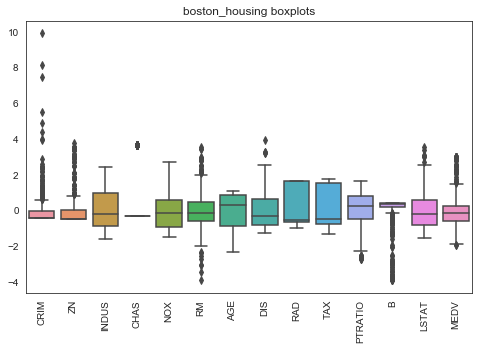

In [7]:
#normalizamos para tener rangos uniformes en histogramas
df_housing_normalizado = (df_housing - df_housing.mean()) / df_housing.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
#bx_plot = sns.boxplot(data=df_housing)
bx_plot = sns.boxplot(data=df_housing_normalizado)
#bx_plot = sns.boxplot(data=df_housing)
plt.title("boston_housing boxplots")
plt.xticks(rotation=90)
plt.show()

### Histograms and scatterplots

Histograms and scatter plots against the target of first 7 fatures.

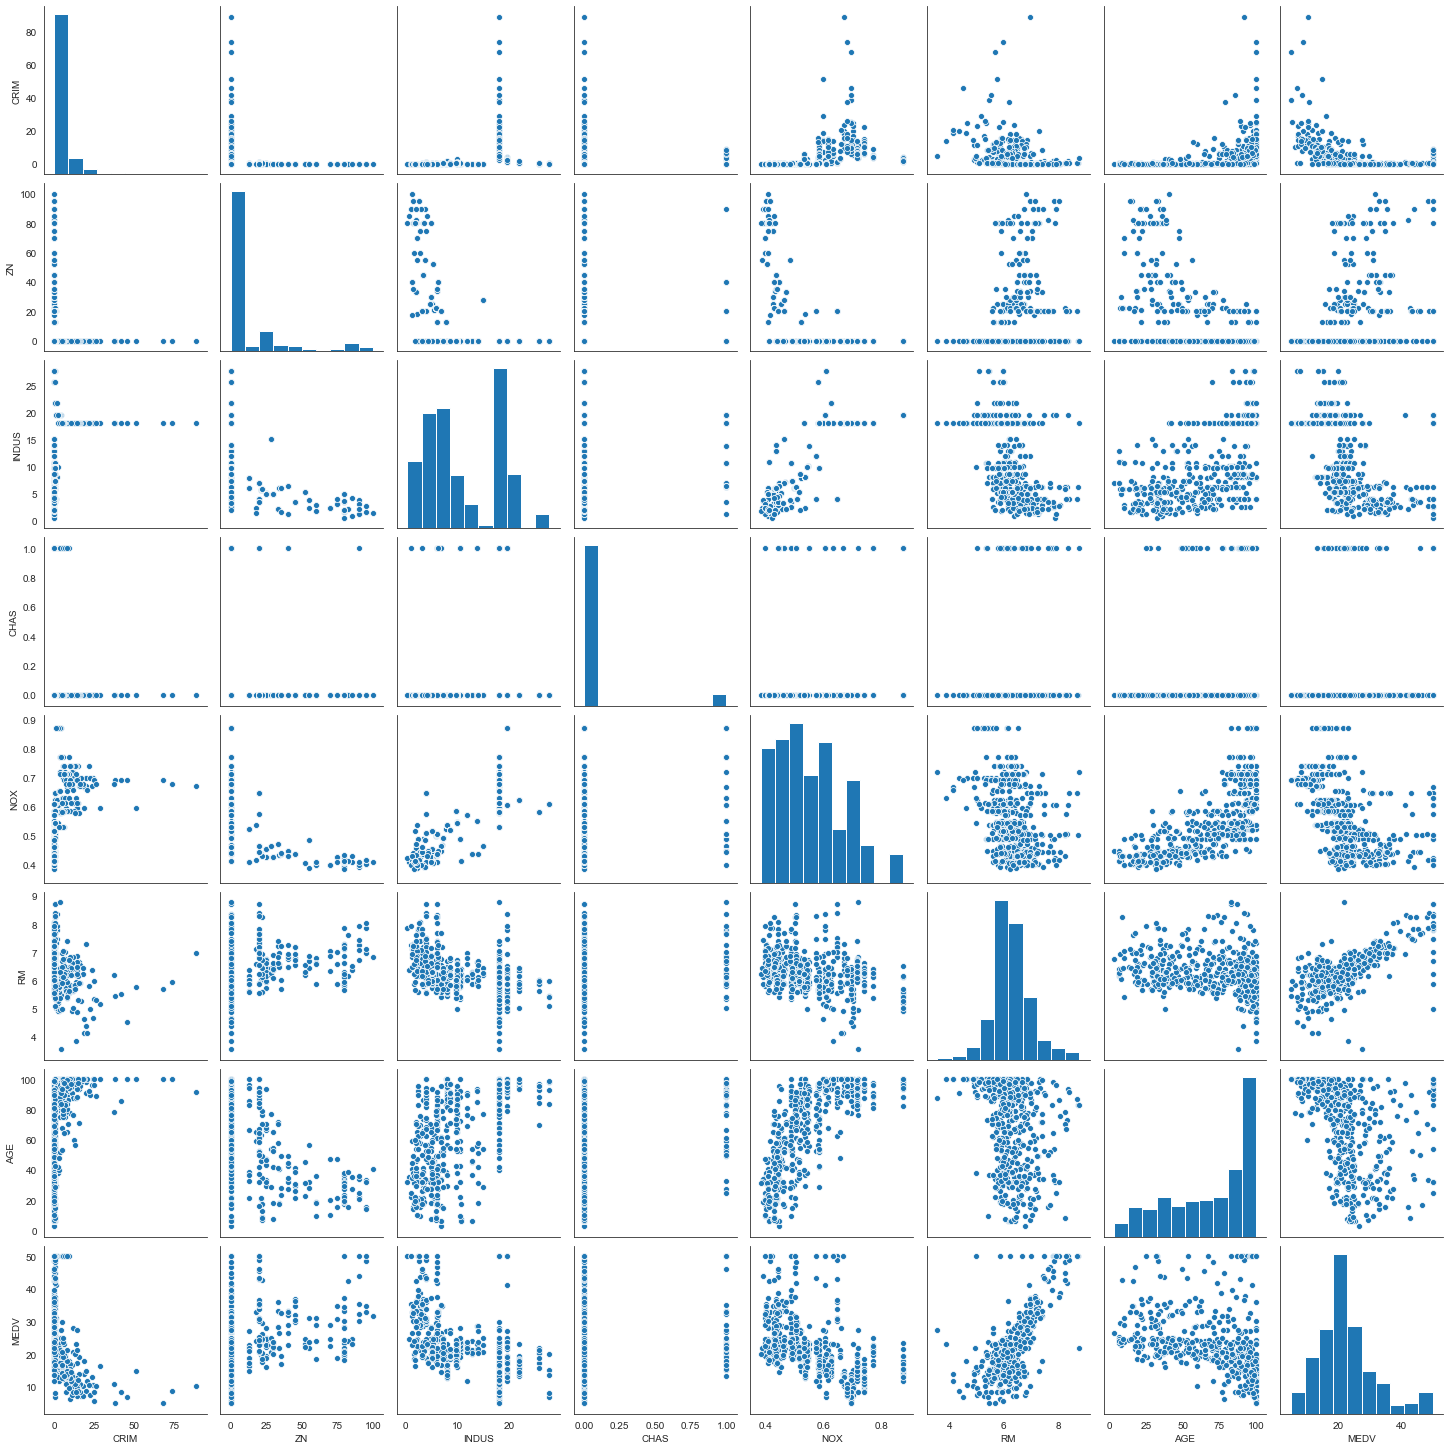

In [8]:
num_vars_to_show = 7 
pair_plot = sns.pairplot( df_housing[ vars_housing[ : num_vars_to_show] + target_housing] )
plt.show()

Histograms and scatter plots against the target of remaining features.

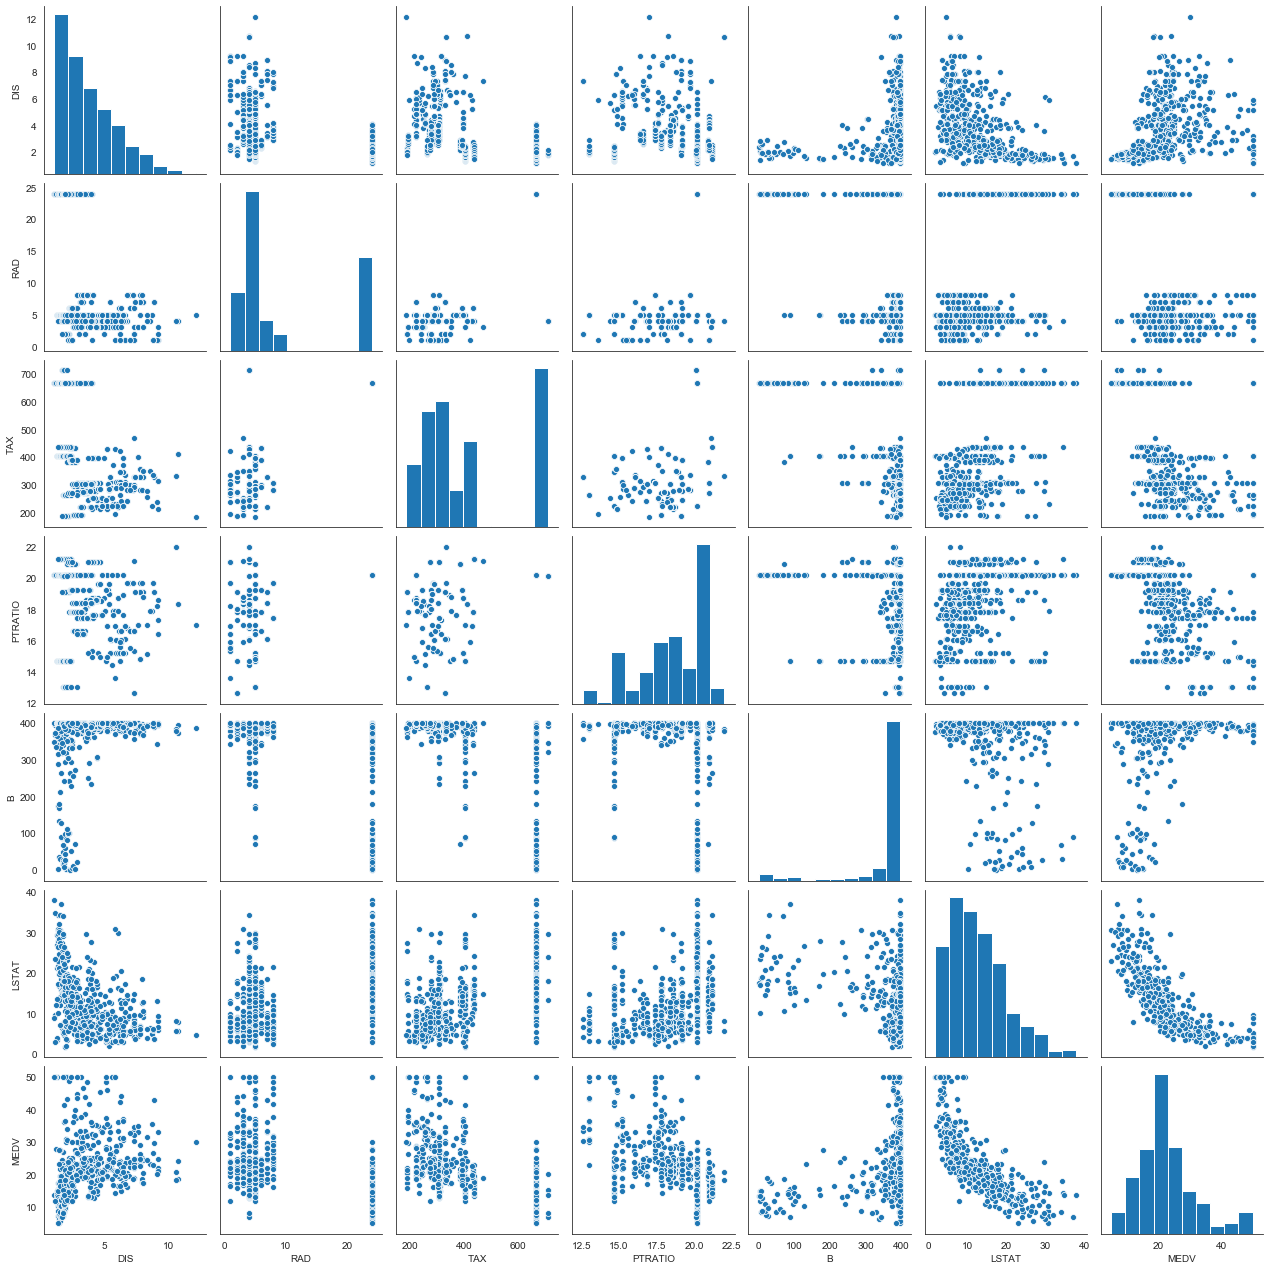

In [9]:
pair_plot = sns.pairplot( df_housing[ vars_housing[ 7: ] + target_housing] )
plt.show()

A few variables seem to have a linear relationship with the target.

### Correlations

In [10]:
df_housing.corr().round(decimals=3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000,-0.200,0.407,-0.056,0.421,-0.219,0.353,-0.380,0.626,0.583,0.290,-0.385,0.456,-0.388
ZN,-0.200,1.000,-0.534,-0.043,-0.517,0.312,-0.570,0.664,-0.312,-0.315,-0.392,0.176,-0.413,0.360
INDUS,0.407,-0.534,1.000,0.063,0.764,-0.392,0.645,-0.708,0.595,0.721,0.383,-0.357,0.604,-0.484
CHAS,-0.056,-0.043,0.063,1.000,0.091,0.091,0.087,-0.099,-0.007,-0.036,-0.122,0.049,-0.054,0.175
NOX,0.421,-0.517,0.764,0.091,1.000,-0.302,0.731,-0.769,0.611,0.668,0.189,-0.380,0.591,-0.427
RM,-0.219,0.312,-0.392,0.091,-0.302,1.000,-0.240,0.205,-0.210,-0.292,-0.356,0.128,-0.614,0.695
AGE,0.353,-0.570,0.645,0.087,0.731,-0.240,1.000,-0.748,0.456,0.506,0.262,-0.274,0.602,-0.377
DIS,-0.380,0.664,-0.708,-0.099,-0.769,0.205,-0.748,1.000,-0.495,-0.534,-0.232,0.292,-0.497,0.250
RAD,0.626,-0.312,0.595,-0.007,0.611,-0.210,0.456,-0.495,1.000,0.910,0.465,-0.444,0.489,-0.382
TAX,0.583,-0.315,0.721,-0.036,0.668,-0.292,0.506,-0.534,0.910,1.000,0.461,-0.442,0.544,-0.469


Una imagen (o un heatmap) vale más que mil palabras

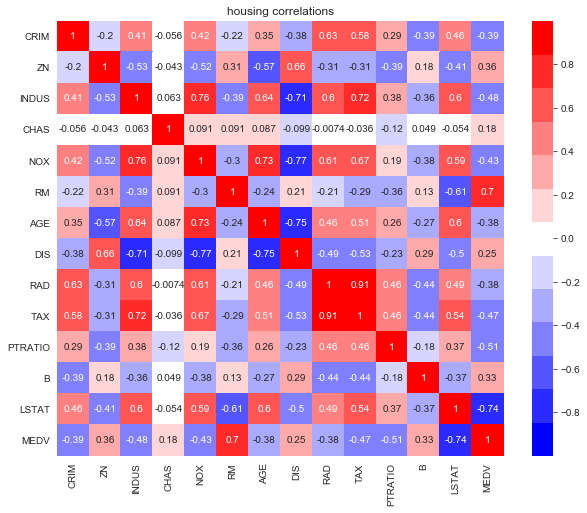

In [11]:
# definir el color map
n_colors = 13
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

# definir el heatmap
fig = plt.figure( figsize=(10, 8))
plt.title('housing correlations')
#plt.colorbar(cMap, ticks=[-1, 0, 1])
h_map = sns.heatmap(df_housing.corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap,
                    annot=True,
                    xticklabels=list(df_housing.columns),
                    yticklabels=list(df_housing.columns))
plt.xticks(rotation=90) 

# poner ticks en la barra de color
cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

# arreglar cosillas
bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

# generar el dibujo
plt.show()

In [12]:
print( ( df_housing.corr()['MEDV'].abs().round(3).sort_values(ascending=False).T) )

MEDV       1.000
LSTAT      0.738
RM         0.695
PTRATIO    0.508
INDUS      0.484
TAX        0.469
NOX        0.427
CRIM       0.388
RAD        0.382
AGE        0.377
ZN         0.360
B          0.333
DIS        0.250
CHAS       0.175
Name: MEDV, dtype: float64


## SV Regressor

We build a first a pipeline model with default values to be hyperparameterized later.

We will work with Gaussian kernels, so we have to set two hyperparameters, `C, gamma` plus the `epsilon` insensitivity. 

In [13]:
x = df_housing[ vars_housing ].values
y = df_housing[ target_housing ].values.reshape(-1,)
num_patterns, dim = x.shape

In [14]:
# scaler + svc pipeline
mm_sc = MinMaxScaler()
svr = SVR(kernel='rbf', 
          shrinking=False, 
          tol=1.e-3)

regr = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                       ('svr', svr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

inner_estimator.fit(x, y)

TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('minmax_sc',
                                                      MinMaxScaler(copy=True,
                                                                   feature_range=(0,
                                                                                  1))),
                                                     ('svr',
                                                      SVR(C=1.0, cache_size=200,
                                                          coef0=0.0, degree=3,
                                                          epsilon=0.1,
                                                          gamma='scale',
                                                          kernel='rbf',
                                                          max_iter=-1,
                                      

In [15]:
svr = inner_estimator.regressor_.named_steps['svr']

print("num_SVs:          ", svr.n_support_)
print("indices_of_svs:   ", svr.support_[ : 10])
print("intercept:        ", svr.intercept_)
print("num SVs_at_bound: ", (abs(svr.dual_coef_) == svr.C).sum())
print("num_SVs:          ", (np.logical_and(abs(svr.dual_coef_) < svr.C, 
                                            abs(svr.dual_coef_) > 0.).sum()))

print("svs:              ", svr.support_vectors_[ : 3, : ])

print("\nsorted_dual_coefs not at bound")
print(np.sort(svr.dual_coef_[ ~(abs(svr.dual_coef_) == svr.C)]))

num_SVs:           [339]
indices_of_svs:    [ 0  1  2  3  4  5  6  7  8 10]
intercept:         [0.40113184]
num SVs_at_bound:  295
num_SVs:           44
svs:               [[0.00000000e+00 1.80000000e-01 6.78152493e-02 0.00000000e+00
  3.14814815e-01 5.77505269e-01 6.41606591e-01 2.69203139e-01
  0.00000000e+00 2.08015267e-01 2.87234043e-01 1.00000000e+00
  8.96799117e-02]
 [2.35922539e-04 0.00000000e+00 2.42302053e-01 0.00000000e+00
  1.72839506e-01 5.47997701e-01 7.82698249e-01 3.48961980e-01
  4.34782609e-02 1.04961832e-01 5.53191489e-01 1.00000000e+00
  2.04470199e-01]
 [2.35697744e-04 0.00000000e+00 2.42302053e-01 0.00000000e+00
  1.72839506e-01 6.94385898e-01 5.99382080e-01 3.48961980e-01
  4.34782609e-02 1.04961832e-01 5.53191489e-01 9.89737254e-01
  6.34657837e-02]]

sorted_dual_coefs not at bound
[-0.99483604 -0.9740674  -0.96806475 -0.96374592 -0.96064762 -0.94581523
 -0.90987406 -0.80612132 -0.78211233 -0.74214489 -0.7367084  -0.67659197
 -0.63148972 -0.6053195  -0.55872046 

### Can we overfit a SVR?

It's easy: just set a large `C` (i.e., very little regularization), a small `epsilon` (i.e., penalize all errors) and a big `gamma` (i.e., use sharp Gaussians).

We do so and predict over the same train set.

In [16]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

svr = SVR(C=1.e5, 
          kernel='rbf', 
          gamma=1.e3/dim, 
          epsilon=0.,
          shrinking=False, 
          tol=1.e-3)

regr = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                       ('svr', svr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

inner_estimator.fit(x, y)
y_pred = inner_estimator.predict(x)

print("mae: %.4f" % mean_absolute_error(y,y_pred))
print("num_SVs:", inner_estimator.regressor_.named_steps["svr"].n_support_)

mae: 0.0016
num_SVs: [504]


But if we do a realistic model evaluation ...

In [17]:
n_folds = 5
kf = KFold(n_folds, shuffle=True)

mae_scores = cross_val_score(inner_estimator, x, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=2)
print("\ncv mae: %.3f" % (-mae_scores.mean()))


cv mae: 4.756


## Hyperparametrization of $C, \gamma, \epsilon$

We do it by grid search CV, but we have to explore **three** hyperparameters, so search times may increase considerably.

We will use 5 folds.

In [18]:
l_C     = [10.**k for k in range(-3, 4)] 
l_gamma = list( np.array([2.**k for k in range(-2, 7)]) / dim)
l_epsilon = [2.**k for k in range(-6, 0)]

param_grid ={'regressor__svr__C': l_C,
             'regressor__svr__gamma': l_gamma,
             'regressor__svr__epsilon': l_epsilon}

print("num_hyperparams", len(l_C) * len(l_gamma) * len(l_epsilon))

cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error', 
                            refit=True,
                            n_jobs=2,
                            return_train_score=True,
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x, y)
print("grid_search_time: %f segundos" % (time.time() - t_0))

f_pkl = open("c_gamma_epsilon_cv_search_housing.pkz", 'wb') 
pickle.dump(cv_estimator, f_pkl)
f_pkl.close()

num_hyperparams 378
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 1348 tasks      | elapsed:   17.8s
[Parallel(n_jobs=2)]: Done 1804 tasks      | elapsed:  2.5min


grid_search_time: 158.215132 segundos


[Parallel(n_jobs=2)]: Done 1890 out of 1890 | elapsed:  2.6min finished


## Analyzing GridSearchCV results

We check the adequacy of the best hyperparameters with respect to the grid range.

In [19]:
f_pkl = open("c_gamma_epsilon_cv_search_housing.pkz", 'rb') 
cv_estimator = pickle.load(f_pkl)
f_pkl.close()

In [20]:
print("C_range: %.4f - %.0f" % (np.array(l_C).min(), np.array(l_C).max()))
print("\tbest_C:", cv_estimator.best_params_['regressor__svr__C']) 

print("gamma_range: %.5f - %.5f" % (np.array(l_gamma).min(), np.array(l_gamma).max()))
print("\tbest_gamma:", cv_estimator.best_params_['regressor__svr__gamma'])

print("epsilon_range: %.5f - %.3f" % (np.array(l_epsilon).min(), np.array(l_epsilon).max()))
print("\tbest_epsilon:", cv_estimator.best_params_['regressor__svr__epsilon'])

C_range: 0.0010 - 1000
	best_C: 10.0
gamma_range: 0.01923 - 4.92308
	best_gamma: 1.2307692307692308
epsilon_range: 0.01562 - 0.500
	best_epsilon: 0.03125


We sort hyperparameters by best CV test score

In [21]:
df_C_gamma_epsilon_search = pd.DataFrame.from_dict(cv_estimator.cv_results_)
df_C_gamma_epsilon_search.sort_values(by='mean_test_score', ascending=False)[['param_regressor__svr__C',\
                                                                      'param_regressor__svr__gamma',\
                                                                      'param_regressor__svr__epsilon',\
                                                                      'mean_test_score']][ : 5]

,param_regressor__svr__C,param_regressor__svr__gamma,param_regressor__svr__epsilon,mean_test_score
231,10,1.23077,0.03125,-2.003221
240,10,1.23077,0.0625,-2.004602
222,10,1.23077,0.015625,-2.023805
249,10,1.23077,0.125,-2.038329
283,100,0.307692,0.03125,-2.059087


Next we plot the CV errors with respect to `C`, `gamma` and `epsilon`.

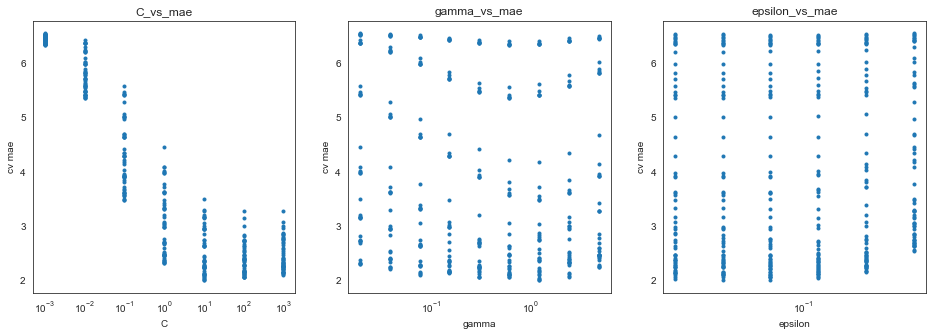

In [22]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
#plt.ylim(1.8, 2.2)
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__C'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 2)
plt.title('gamma_vs_mae')
plt.xlabel('gamma')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__gamma'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 3)
plt.title('epsilon_vs_mae')
plt.xlabel('epsilon')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__epsilon'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.show()

This less clear than for, say, linear regression, as there are many hyperparamter combinations.

We can try to fix two hyperparameters to their optimal values and then draw the third one, although we can miss some optimal or near optimal combinations.

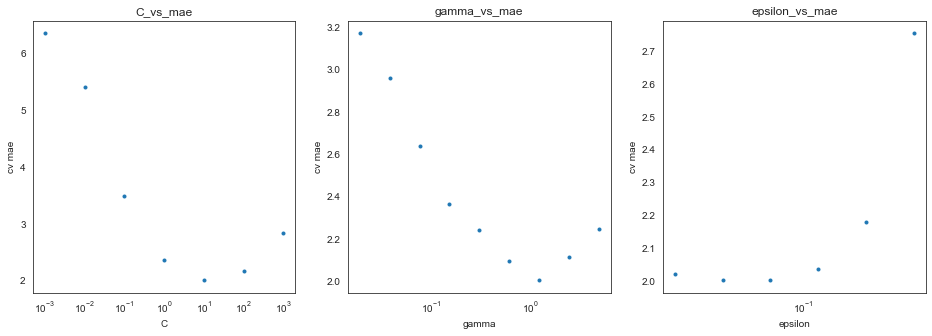

In [23]:
best_C = cv_estimator.best_params_['regressor__svr__C']
best_gamma = cv_estimator.best_params_['regressor__svr__gamma']
best_epsilon = cv_estimator.best_params_['regressor__svr__epsilon']

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
idx_best_gamma_eps = np.logical_and(df_C_gamma_epsilon_search['param_regressor__svr__gamma'] == best_gamma, 
                                    df_C_gamma_epsilon_search['param_regressor__svr__epsilon'] == best_epsilon)
_ = plt.plot( df_C_gamma_epsilon_search[idx_best_gamma_eps]['param_regressor__svr__C'], 
             -df_C_gamma_epsilon_search[idx_best_gamma_eps]['mean_test_score'], '.')

plt.subplot(1, 3, 2)
plt.title('gamma_vs_mae')
plt.xlabel('gamma')
plt.ylabel('cv mae')
plt.xscale('log')
idx_best_C_eps = np.logical_and(df_C_gamma_epsilon_search['param_regressor__svr__C'] == best_C, 
                                df_C_gamma_epsilon_search['param_regressor__svr__epsilon'] == best_epsilon)
_ = plt.plot( df_C_gamma_epsilon_search[idx_best_C_eps]['param_regressor__svr__gamma'], 
             -df_C_gamma_epsilon_search[idx_best_C_eps]['mean_test_score'], '.')

plt.subplot(1, 3, 3)
plt.title('epsilon_vs_mae')
plt.xlabel('epsilon')
plt.ylabel('cv mae')
plt.xscale('log')
idx_best_C_gamma = np.logical_and(df_C_gamma_epsilon_search['param_regressor__svr__C'] == best_C, 
                                  df_C_gamma_epsilon_search['param_regressor__svr__gamma'] == best_gamma)
_ = plt.plot( df_C_gamma_epsilon_search[idx_best_C_gamma]['param_regressor__svr__epsilon'], 
             -df_C_gamma_epsilon_search[idx_best_C_gamma]['mean_test_score'], '.')

plt.show()

## Testing the final model

We do it first by CV.

In [24]:
best_estimator = cv_estimator.best_estimator_

scores = cross_val_score(best_estimator, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=2)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 2.109		mae_std: 0.190


We can get CV fold predictions with `cross_val_predict`.

In [25]:
from sklearn.model_selection import cross_val_predict

y_pred = np.clip( cross_val_predict(best_estimator, x, y, cv=kf, n_jobs=2), 5., 50.)

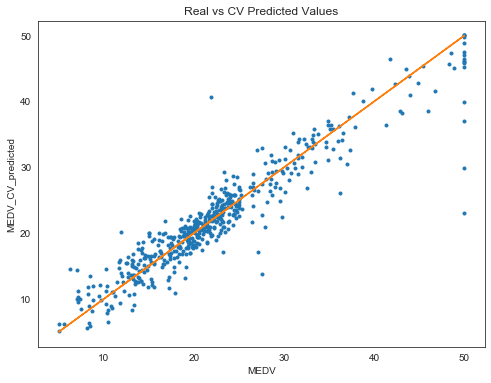

In [26]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_CV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

### Residual histograms and relationship with targets

mae: 2.030


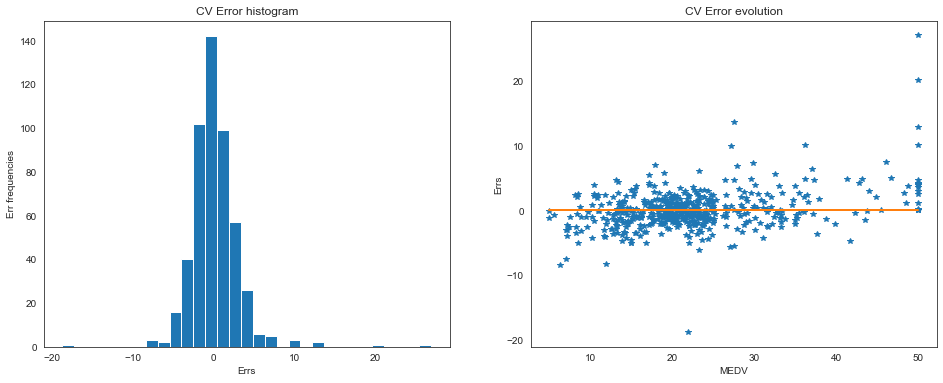

In [27]:
err = y - y_pred

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()